Размер выборки для группы: 10.209542630107556
Количество пользователей в отфильтрованных данных:
  sort  count
0  new     12
1  old     12
TtestResult(statistic=np.float64(4.213528418779408), pvalue=np.float64(0.000358164887896205), df=np.float64(22.0))


([<matplotlib.patches.Wedge at 0x1ed38262d80>,
 [Text(-0.6261106094193057, -0.9044255109032395, 'new'),
  Text(0.6261107459837514, 0.9044254163631573, 'old')],
 [Text(-0.3415148778650758, -0.49332300594722145, '52.9%'),
  Text(0.3415149523547734, 0.4933229543799039, '47.1%')])

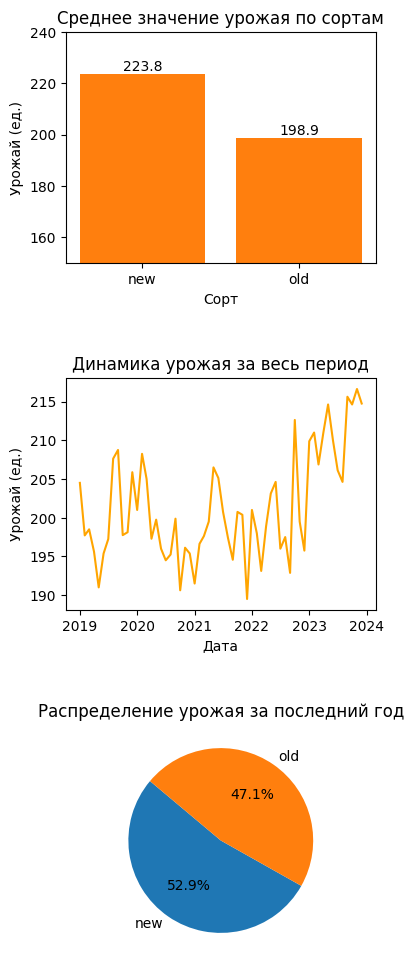

In [138]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats as sp
from statsmodels.stats.power import TTestIndPower

df = pd.read_csv('D:/coffee_data.csv')
df = df.dropna() # удаление пустых строк
average_harvest = np.median(df['harvest']) # среднее значение по медиане
df.loc[df['harvest']>500, 'harvest'] = average_harvest # замена аномальных выбросов значением медианы

df['month'] = pd.to_datetime(df['month']) # данные на урожай до 2023 года и после.
old_data = df.loc[df['month'] < '2023-01-01']
new_data = df.loc[df['month'] >= '2023-01-01']

# Стандартное отклонение по историческим данным и минимальный детектируемый эффект
st = old_data['harvest'].std()
mde = 20 / st # 20 кг дано по условию

# Размер выборки
sample_size = TTestIndPower().solve_power(effect_size=mde, alpha=0.05, power=0.8) # 0.05 и 0.8 дано по условию

# Количество пользователей в каждой группе по дате
user_count_by_date = new_data.groupby(['month', 'sort']).size().reset_index(name='count')
user_count_by_date['cum_count'] = user_count_by_date.groupby('sort')['count'].cumsum()

# Минимальные даты, когда количество пользователей в каждой группе достигает sample_size
group_a_sample_date = user_count_by_date[user_count_by_date['sort'] == 'new'].loc[user_count_by_date['cum_count'] >= sample_size, 'month'].min()
group_b_sample_date = user_count_by_date[user_count_by_date['sort'] == 'old'].loc[user_count_by_date['cum_count'] >= sample_size, 'month'].min()

# Макс из двух дат, чтобы обе группы достигли необходимого размера выборки
sample_date = max(group_a_sample_date, group_b_sample_date)

# Фильтр по дате
ab_df = new_data.loc[new_data['month'] <= sample_date]

# Количество пользователей в каждой группе после фильтрации
control_group = ab_df.groupby(['sort']).size().reset_index(name='count')

print(f'Размер выборки для группы: {sample_size}')
print(f'Количество пользователей в отфильтрованных данных:\n{control_group}')

# Выполняем t-тест
t_test_result = sp.ttest_ind(
    ab_df['harvest'].loc[ab_df['sort'] == 'new'],
    ab_df['harvest'].loc[ab_df['sort'] == 'old']
)
print(t_test_result)

dynamic_harvest = df.groupby(['month'], as_index=False)['harvest'].mean()
avg_to_system = new_data.groupby(['sort'], as_index=False)['harvest'].mean()

fig, ax = plt.subplots(3, figsize=(4,12))
plt.subplots_adjust(hspace=0.5)

bars = ax[0].bar(avg_to_system['sort'], avg_to_system['harvest'])
ax[0].bar(avg_to_system['sort'],avg_to_system['harvest'])
ax[0].set_title('Среднее значение урожая по сортам')
ax[0].set_xlabel('Сорт')
ax[0].set_ylabel('Урожай (ед.)')
ax[0].set_ylim(bottom=150, top =240) 
for bar in bars:
    height = bar.get_height()
    rounded_height = round(height, 1)  # Округление до одного знака после запятой
    ax[0].text(
        bar.get_x() + bar.get_width() / 2,  # x-координата
        height,  # y-координата
        f'{rounded_height}',  # округленное значение
        ha='center',  # выравнивание по горизонтали
        va='bottom'  # выравнивание по вертикали)
    )

ax[1].plot(dynamic_harvest['month'],dynamic_harvest['harvest'],color='orange')
ax[1].set_title('Динамика урожая за весь период')
ax[1].set_xlabel('Дата')
ax[1].set_ylabel('Урожай (ед.)')

ax[2].set_title('Распределение урожая за последний год')
explode = (0,0) # Для визуального выделения одной секции (на примере Berlin)
ax[2].pie(x=avg_to_system['harvest'], 
        labels=avg_to_system['sort'], 
        autopct='%1.1f%%', # формат подписей
        explode=explode,
        # shadow=True, # тень
        startangle=140)